In [15]:
import folium 
import math
import pandas as pd
import numpy as np
import requests
import geopy.distance
import json
import seaborn as sns
import matplotlib.pyplot as plt

# In the city of Lyon, the third largest city in France, someone is looking to open a restaurant, where should they open it?

## Introduction/Business Problem

*Clearly define a problem or an idea of your choice, where you would need to leverage the Foursquare location data to solve or execute. Remember that data science problems always target an audience and are meant to help a group of stakeholders solve a problem, so make sure that you explicitly describe your audience and why they would care about your problem.*

Most restaurants fail quickly and 60% go out of business within three years of opening, largely due to fundamental flaws in the planning of the operation[\*](https://www.menucoverdepot.com/resource-center/articles/restaurant-failure/). Among key factors are the location, a marketing plan, a service scheme, design, atmosphere, price point and a defined position in relationship to the competition. **Location** may come first, especially when viewed in relation with the competition. This is the very point that leads some to say that "McDonald’s isn’t just a fast-food chain, it’s a brilliant $30 billion real-estate company[\*](https://qz.com/965779/mcdonalds-isnt-really-a-fast-food-chain-its-a-brilliant-30-billion-real-estate-company/)." In Lyon as in any other place, one should carrefully study potential locations in regard to the competition before investing in a restaurant, and that's when data from [Foursquare](https://foursquare.com/) can help.

## Data

*Describe the data that you will be using to solve the problem or execute your idea. Remember that you will need to use the Foursquare location data to solve the problem or execute your idea. You can absolutely use other datasets in combination with the Foursquare location data. So make sure that you provide adequate explanation and discussion, with examples, of the data that you will be using, even if it is only Foursquare location data.*

Foursquare gives access to some of their data through an API. There are several tiers that give access to different data. The company boasts about 62M+ Global Venues, 190+ Countries and 50 Territories, 900+ Venue Categories and 30+ Attribute Fields. But countries and territories are unevenly covered. We'll see that **regarding Lyon, data are few and we can only hope that they are representative of the overall trend**. Out of all the venues, we'll be interesting in venues that are restaurants and in venues that call for restaurants in the neighboroud.

The categories are a hierarchized tree avaialble [here](https://developer.foursquare.com/docs/resources/categories). I shortened the labels of these categories in this study:
* `Food` → *food*
* `Arts & Entertainment`, aka your competition → *fun*
* `College & University` → *school*
* `Travel & Transport` → *transport*
* `Business Center` → *business*

Venues in the *food* category belong to subcategories. These subcategories are unfortunatelly a bit too accurate considering the amount of data available in Lyon. It may be interesting to train a clusterizing mean in cities with more data and to applied that trained mean in Lyon to have less subcategories with more venues in each. But let's have a look for now on exactly what known restaurants are in Lyon.

### The known restaurants in Lyon and the subcategories they belong to

Set up variables needed to query Foursquare. `CLIENT_ID` and `CLIENT_SECRET` are retrieved from a json file which is listed in the `.gitignore` file so that changes to the project can be easly pushed to GitHub with no risk of making these security data public.

In [16]:
CLIENT_ID = 'A'
CLIENT_SECRET = 'B'
with open('week_4_foursquare_connection.json', 'r') as f:
    foursquare_connection = json.load(f)
    CLIENT_ID = foursquare_connection['CLIENT_ID']
    CLIENT_SECRET = foursquare_connection['CLIENT_SECRET']
VERSION = '20200131'
LIMIT = 300
radius = 3000
latitude = 45.7640
longitude = 4.8357
url_format = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'

In [17]:
fun_url = url_format.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, 'Arts & Entertainment', radius, LIMIT)
fun_json = requests.get(fun_url).json()
school_url = url_format.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, 'College & University', radius, LIMIT)
school_json = requests.get(school_url).json()
food_url = url_format.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, 'Food', radius, LIMIT)
food_json = requests.get(food_url).json()
transport_url = url_format.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, 'Travel & Transport', radius, LIMIT)
transport_json = requests.get(transport_url).json()
business_url = url_format.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, 'Business Center', radius, LIMIT)
business_json = requests.get(business_url).json()

In [18]:
restaurants = []
for venue in food_json['response']['venues']:
    name = venue['name']
    if 'address' in venue['location']:
        name = name + ', ' + venue['location']['address']
    for category in venue['categories']:
        restaurants.append([name, category['shortName']])
    # print(venue['name'])
restaurants = pd.DataFrame(restaurants)
restaurants.columns = ['NameAddress', 'Category']
restaurants.to_csv('week_4_restaurants.csv', index=False)
restaurants.head()

,NameAddress,Category
0,"Halal Burger Chicken Class Food, 8 rue Sainte ...",Snacks
1,"Food Traboule, 22 rue du Boeuf",Food Court
2,Class Food,Fried Chicken
3,"simple food, 67 Rue De Marseille",Diner
4,"China Fast Food, 9 rue de l'Ancienne Préfecture",Chinese


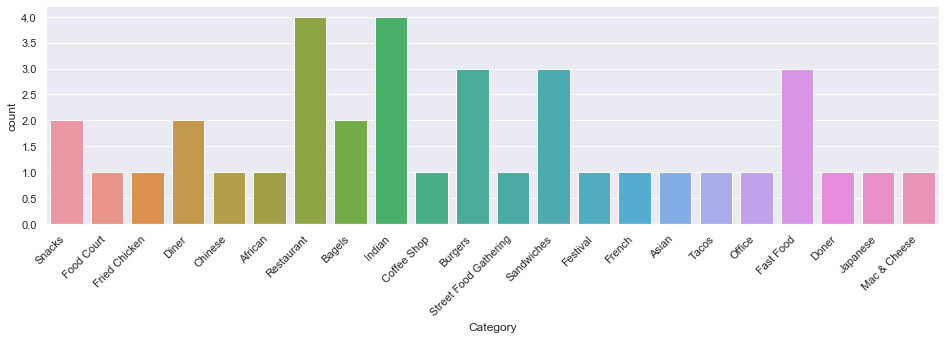

In [19]:
chart = sns.countplot(x="Category", data=restaurants)
sns.set(rc={'figure.figsize':(16,4)})
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.get_figure().savefig("week_4_occurences.png")
chart

### The known restaurants in Lyon and other related venues, and where they are located

In [20]:
data = []
for venues_category, venues_json in [('food', food_json), ('fun', fun_json), ('school', school_json), ('transport', transport_json), ('business', business_json)]:
    for venue in venues_json['response']['venues']:
        address = ''
        if 'address' in venue['location']:
            address = venue['location']['address']
        data.append([venue['name'], venues_category, address, venue['location']['lat'], venue['location']['lng']])
data = pd.DataFrame(data)
data.columns = ['Name', 'Category', 'Address', 'Latitude', 'Longitude']
data.head()

,Name,Category,Address,Latitude,Longitude
0,Halal Burger Chicken Class Food,food,8 rue Sainte Marie des Terreaux,45.767643,4.832869
1,Food Traboule,food,22 rue du Boeuf,45.762966,4.827019
2,Class Food,food,,45.767136,4.833096
3,simple food,food,67 Rue De Marseille,45.767726,4.837527
4,China Fast Food,food,9 rue de l'Ancienne Préfecture,45.760146,4.833297


We will display the restaurants and related venues in Lyon. Notice the dictionary used to map categories to colors (red for *food*, green for *fun*, blue for *school*, yellow for *transport* and purple for *business*.

In [21]:
display = {
    'fun' : { 'color': 'green' },
    'school' : { 'color': 'blue' },
    'transport': { 'color': 'yellow' },
    'business' : { 'color': 'purple' },
    'food' : { 'color': 'red' }
}
map_lyon = folium.Map(location=[latitude, longitude], zoom_start=13)
for name, address, category, lat, lng in zip(data['Name'], data['Address'], data['Category'], data['Latitude'], data['Longitude']):
    label = name
    if address != '':
        label = label + ', ' + address
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=display[category]['color'],
        fill=True,
        fill_color=display[category]['color'],
        fill_opacity=0.7,
        parse_html=False).add_to(map_lyon) 
map_lyon.save("week_4_map.html")
map_lyon

We can notice that there's only one venue in the *transport* category, near the train station *Gare de Lyon*. There's no venue in the *transport* category near the train station *Lyon Perrache* which about as big as *Gare de Lyon*. This is a proof that a lot of data is missing from the Foursquare database.

We can see many restaurants near the city center, where there are also most of the venues with customers for these restaurants. But the proportion between the density of restaurants and the density of other venues seems do decrease when going away from the center. Let's see the impact of this change in the densitiesby studying how far is any venue from the nearest restaurant.

### The venues related to restaurants in Lyon and how far are they from the nearest restaurant

In [22]:
data_food = data[data['Category'] == 'food']
data_else = data[data['Category'] != 'food']
result =[]
for venue in data_else.values:
    distance_min = math.inf
    for food in data_food.values:
        distance_min = min(distance_min, geopy.distance.distance((venue[3], venue[4]), (food[3], food[4])).m)
    result.append(distance_min)
data_else['DistanceToFood'] = result
data_food['DistanceToFood'] = [250] * len(data_food)
venues = pd.concat([data_else, data_food])
venues = venues.sort_values(by='DistanceToFood', ascending=False)
venues.to_csv('week_4_venues.csv', index=False)
venues

C:\_\run\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\_\run\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Name,Category,Address,Latitude,Longitude,DistanceToFood
96,College Charles Senard,school,,45.790664,4.842980,2386.719074
138,Health Club,business,Hilton Lyon Hotel,45.784652,4.853082,1820.112047
105,Business & Decision,business,,45.785110,4.855372,1800.690422
139,Fitness Center @Crowne Plaza,business,,45.785289,4.856860,1785.472094
137,Body Gym Center,business,40 Avenue Henri Barbusse,45.767245,4.879308,1304.989781
...,...,...,...,...,...,...
38,Musée des Beaux-Arts,fun,20 Place des Terreaux,45.766772,4.833712,62.726575
60,Jardins du Palais Saint-Pierre,fun,,45.766804,4.833660,57.352797
41,Quai des Arts,fun,8 bis Quai Saint-Vincent,45.767783,4.817837,44.299869
58,Ensba - Ecole Supérieure Nationale des Beaux A...,fun,18 quai saint vincent,45.767957,4.817419,7.206817


We now display the venues with circles that are bigger when the venue is the farther from the nearest restaurant. Restaurants (still in red), have a fix size.

In [23]:
display = {
    'fun' : { 'color': 'green' },
    'school' : { 'color': 'blue' },
    'transport': { 'color': 'yellow' },
    'business' : { 'color': 'purple' },
    'food' : { 'color': 'red' }
}
map_lyon = folium.Map(location=[latitude, longitude], zoom_start=13)
for name, address, category, lat, lng, dist in zip(venues['Name'], venues['Address'], venues['Category'], venues['Latitude'], venues['Longitude'], venues['DistanceToFood']):
    label = name
    if address != '':
        label = label + ', ' + address
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=dist/50,
        popup=label,
        color=display[category]['color'],
        fill=True,
        fill_color=display[category]['color'],
        fill_opacity=0.7,
        parse_html=False).add_to(map_lyon) 
map_lyon.save("week_4_map.html")
map_lyon

It clearly appears that some venues are far away from any restaurant. This map could clearly help if the strategy is to find a location with the potential customers untaped by the competion.